<a href="https://colab.research.google.com/github/harperd17/cloud_classification/blob/main/modeling/modeling_thresholded_masks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook aims to subset the masks to only have pixels that are clouds

Currently there are regions of pixels that are classified as being clouds of a certain type while many of the pixels are not actually clouds. I want to see if I'm able to subset these classified pixels into only pixels that have clouds since that should be a more accurate classification

In [ ]:
!git clone https://github.com/harperd17/cloud_classification.git

Cloning into 'cloud_classification'...
remote: Enumerating objects: 151, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 151 (delta 28), reused 0 (delta 0), pack-reused 84
Receiving objects: 100% (151/151), 11.18 MiB | 2.92 MiB/s, done.
Resolving deltas: 100% (58/58), done.


In [ ]:
!git clone https://github.com/EdwardRaff/Inside-Deep-Learning.git
%run /content/Inside-Deep-Learning/idlmam.py

Cloning into 'Inside-Deep-Learning'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 34 (delta 10), reused 28 (delta 7), pack-reused 0
Unpacking objects: 100% (34/34), done.


In [ ]:
!pip install torchsat

     |████████████████████████████████| 46 kB 3.3 MB/s 


In [ ]:
from cloud_classification.helpers.helper_functions import CloudData, show_image_and_masks, decode_pixels, train_network, show_predicted_masks, get_accuracy, get_auc

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
from torch.utils.data import Dataset
import torch
import torchvision
import torch.nn.functional as F
from PIL import Image

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
drive._mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#%cd /content/drive/MyDrive/Data690/Project/Data
#%cd /content/drive/Shareddrives/DavidHarper_Data690_Project/Data

/content/drive/Shareddrives/DavidHarper_Data690_Project/Data


In [ ]:
data_dir = '/content/drive/Shareddrives/DavidHarper_Data690_Project/Data'
#data_dir = '/content/drive/MyDrive/Data690/Project/Data'

In [ ]:
train_data = pd.read_csv(data_dir+'/train.csv')

In [ ]:
from skimage.filters import threshold_local

I have created a new version of the CloudData class which does the thresholding

In [ ]:
class CloudDataCloudsOnly(Dataset):
  """This class is used for the cloud data"""
  def __init__(self, data_directory = None, mask_df = None, data_type = 'train', transform=None, output_width=256, output_height=256, normalize_func = None, block_size=21):
    """Instantiate the CloudData object.
    
    Arguments
    ---------
    data_directory (str) - path of where the images are saved. Defaults to None.
    
    mask_df (pd.DataFrame) - the dataframe of the training data image names and labels, and encoded pixels. Defaults to None.
    
    data_type (str) - whether the data is of type train or test. If it is test, there is no mask information and only the images are gathered. Defaults to "train".
    
    transform (torch.transforms) - pytorch transform(s) to have applied to the images. Defaults to BASIC_TRANSFORM which simply converts image to tensor.
    
    output_width (int) - the width to have the image tensor and masks outputted at.
    
    output_height (int) - the height to have the image tensor and masks outputted at.
    """
    super(CloudDataCloudsOnly,self).__init__()
    # the Image_Label field in the mask_df is a string with format {image_name}_{image_label} and need to be broken into two pieces
    mask_df['Label'] = [parts[1] for parts in mask_df['Image_Label'].str.split('_')]
    mask_df['Image'] = [parts[0] for parts in mask_df['Image_Label'].str.split('_')]
    # we are only interested in having one item per unique image and the output for each image will be one mask per class
    self.unique_images = mask_df['Image'].unique()
    self.mask_df = mask_df
    # we need to know the list of unique classes
    self.classes = list(mask_df['Label'].unique())
    self.data_type = data_type
    self.data_directory = data_directory
    self.transform = transform
    self.normalize_func = normalize_func
    self.block_size = block_size
    self.output_width = output_width
    self.output_height = output_height

  def __getitem__(self, idx):
    # get the image name
    image_name = self.unique_images[idx]
    idx_images = self.mask_df[self.mask_df['Image']==image_name]
    # decode the "EncodedPixels" into the mask for each of the classes
    masks = []
    for c in self.classes:
      mask_subset = idx_images[idx_images['Label']==c]
      if mask_subset.shape[0] > 0:
        masks.append(torch.tensor(decode_pixels(mask_subset.iloc[0]['EncodedPixels'], label=1)))
      else:
        masks.append(torch.tensor(decode_pixels(np.nan)))
    
    # get the actual image
    image = Image.open(self.data_directory+'/train_images/'+image_name)
    # get the thresholded version of the image
    image_tensor = torchvision.transforms.ToTensor()(image)
    image_thresholds = threshold_local(np.dot((image_tensor.permute(1,2,0).numpy()*255).astype(np.uint8),[0.299,0.587,0.114]),self.block_size)
    thresholded_image = torch.tensor((np.dot((image_tensor.permute(1,2,0).numpy()*255).astype(np.uint8),[0.299,0.587,0.114]) > image_thresholds)).float()
    masks = [mask*thresholded_image for mask in masks]
    del image # save memory
    resized_image = (F.interpolate(image_tensor.unsqueeze(0), (self.output_width, self.output_height))).squeeze(0).float()
    resized_mask = (F.interpolate(torch.stack(masks).unsqueeze(0), (self.output_width, self.output_height))).squeeze(0).float()
    if self.transform is None:
      if self.normalize_func is None:
        return resized_image, resized_mask
      else:
        return_img, return_mask = self.normalize_func(resized_image, resized_mask)
        return return_img, return_mask.float()
    else:
      if self.normalize_func is None:
        return_img, return_mask = self.perform_transform(resized_image, resized_mask,self.transform)
        return return_img, return_mask.float()
      else:
        return_img, return_mask = self.normalize_func(self.perform_transform(resized_image,resized_mask,self.transform))
        return return_img, return_mask.float()

    #return resized_image.squeeze(0).float(), resized_mask.squeeze(0).float()

  def __len__(self):
    return len(self.unique_images)

  def perform_transform(self,img, mask, transform_list):
    img = (img.permute(1,2,0).numpy()*255).astype(np.uint8)
    mask = (mask.permute(1,2,0).numpy()*255).astype(np.uint8)
    transformed_img, transformed_mask = transforms_seg.Compose(
        transform_list
    )(img, mask)                                                                                               
    return torch.tensor(transformed_img/255,dtype=torch.float32).permute(2,0,1), torch.tensor(transformed_mask/255,dtype=torch.float32).permute(2,0,1)

# Modeling

In [ ]:
!pip install torchsat
from torchsat.transforms import transforms_seg

In [ ]:
import torch
import torchvision
import glob
from PIL import Image
import cv2
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp

     |████████████████████████████████| 88 kB 3.6 MB/s 
     |████████████████████████████████| 58 kB 7.4 MB/s 
     |████████████████████████████████| 376 kB 23.5 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=bf1b9db1c630ff53385443c18ca3853b62ea63a84a705ed8ac21962c9226df2f
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=355fced39cfca8376f3a30861e1f0a78c852b952d788743afcff061deb4c0a52
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
from tqdm.autonotebook import tqdm
from cloud_classification.helpers.helper_functions import CloudData, show_image_and_masks, decode_pixels, train_network, show_predicted_masks, moveTo

from sklearn.metrics import roc_curve, auc

In [ ]:
train_data['Image'] = [parts[0] for parts in train_data['Image_Label'].str.split('_')]
train_data['Label'] = [parts[1] for parts in train_data['Image_Label'].str.split('_')]

In [ ]:
# now random sample from the train_data so that I don't have to train these networks on such a large amount of data - the final model should be trained with all the data though
image_names = pd.Series([parts[0] for parts in train_data['Image_Label'].str.split('_')])
sampled = pd.Series(pd.Series(image_names).unique()).sample(250)
train_data_sampled = train_data[image_names.isin(sampled)]

## Do a Train / Validation Split

In [ ]:
train_valid_images, test_images = train_test_split(sampled,train_size=0.9)
train_images, valid_images = train_test_split(train_valid_images,train_size=0.8)

In [ ]:
test = train_data[image_names.isin(test_images)]
train = train_data[image_names.isin(train_images)]
valid = train_data[image_names.isin(valid_images)]

## Create the CloudData objects and DataLoaders

In [ ]:
output_height = 512
output_width=512

normalize_func = transforms_seg.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

test_dataset = CloudDataCloudsOnly(data_dir, test, normalize_func = normalize_func, output_width=output_width, output_height=output_height)
train_dataset = CloudDataCloudsOnly(data_dir, train, normalize_func = normalize_func, output_width=output_width, output_height=output_height)
valid_dataset = CloudDataCloudsOnly(data_dir, valid, normalize_func = normalize_func, output_width=output_width, output_height=output_height)


batch_size = 12

test_loader = DataLoader(test_dataset,batch_size=batch_size)
train_loader = DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset,batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Get the GPU Device Configured

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [ ]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = None#'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model_resnet_imagenet = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=4, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
normalize_func = transforms_seg.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

output_width=512
output_height=512

test_dataset = CloudDataCloudsOnly(data_dir, test, output_width=output_width, output_height=output_height, normalize_func = normalize_func)#preprocessing=preprocessing_fn)
train_dataset = CloudDataCloudsOnly(data_dir, train, output_width=output_width, output_height=output_height, normalize_func = normalize_func)#preprocessing=preprocessing_fn)
valid_dataset = CloudDataCloudsOnly(data_dir, valid, output_width=output_width, output_height=output_height, normalize_func = normalize_func)#preprocessing=preprocessing_fn)

batch_size = 12

test_loader = DataLoader(test_dataset,batch_size=batch_size)
train_loader = DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset,batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
loss_func = smp.losses.DiceLoss(mode='multilabel')
optimizer = torch.optim.Adam(model_resnet_imagenet.parameters())

In [ ]:
results = train_network(model_resnet_imagenet, loss_func, train_loader, epochs=15, device=device, val_loader=valid_loader, optimizer=optimizer, score_funcs={'Accuracy':get_accuracy,'AUC':get_auc})

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

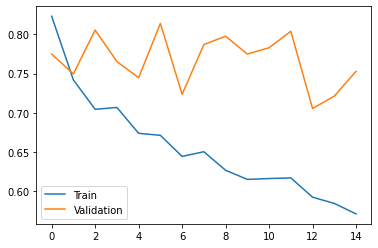

In [ ]:
plt.plot(results['train loss'],label='Train')
plt.plot(results['val loss'],label='Validation')
plt.legend();

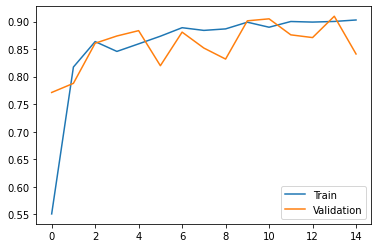

In [ ]:
plt.plot(results['train Accuracy'],label='Train')
plt.plot(results['val Accuracy'],label='Validation')
plt.legend();

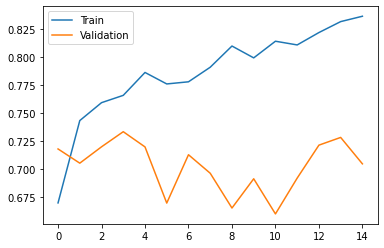

In [ ]:
plt.plot(results['train AUC'],label='Train')
plt.plot(results['val AUC'],label='Validation')
plt.legend();

In [ ]:
model_resnet_imagenet = model_resnet_imagenet.cpu()

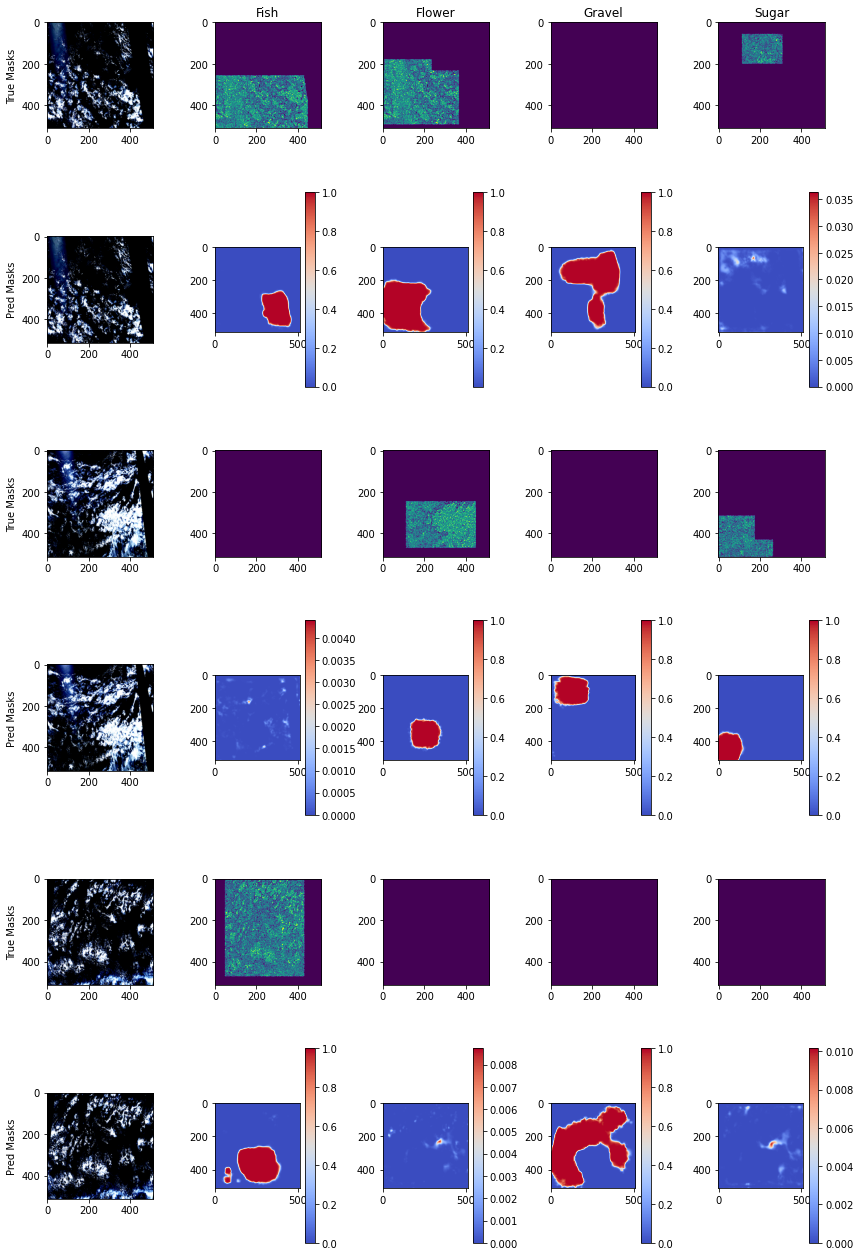

In [ ]:
to_show = 3
with torch.no_grad():
  sample_predictions = [model_resnet_imagenet(train_dataset[i][0].unsqueeze(0)).squeeze(0) for i in range(to_show)]
  sample_masks = [train_dataset[i][1] for i in range(to_show)]
  original_images = [train_dataset[i][0].permute(1,2,0) for i in range(to_show)]
show_predicted_masks(sample_predictions,sample_masks, original_images,classes=train_dataset.classes);

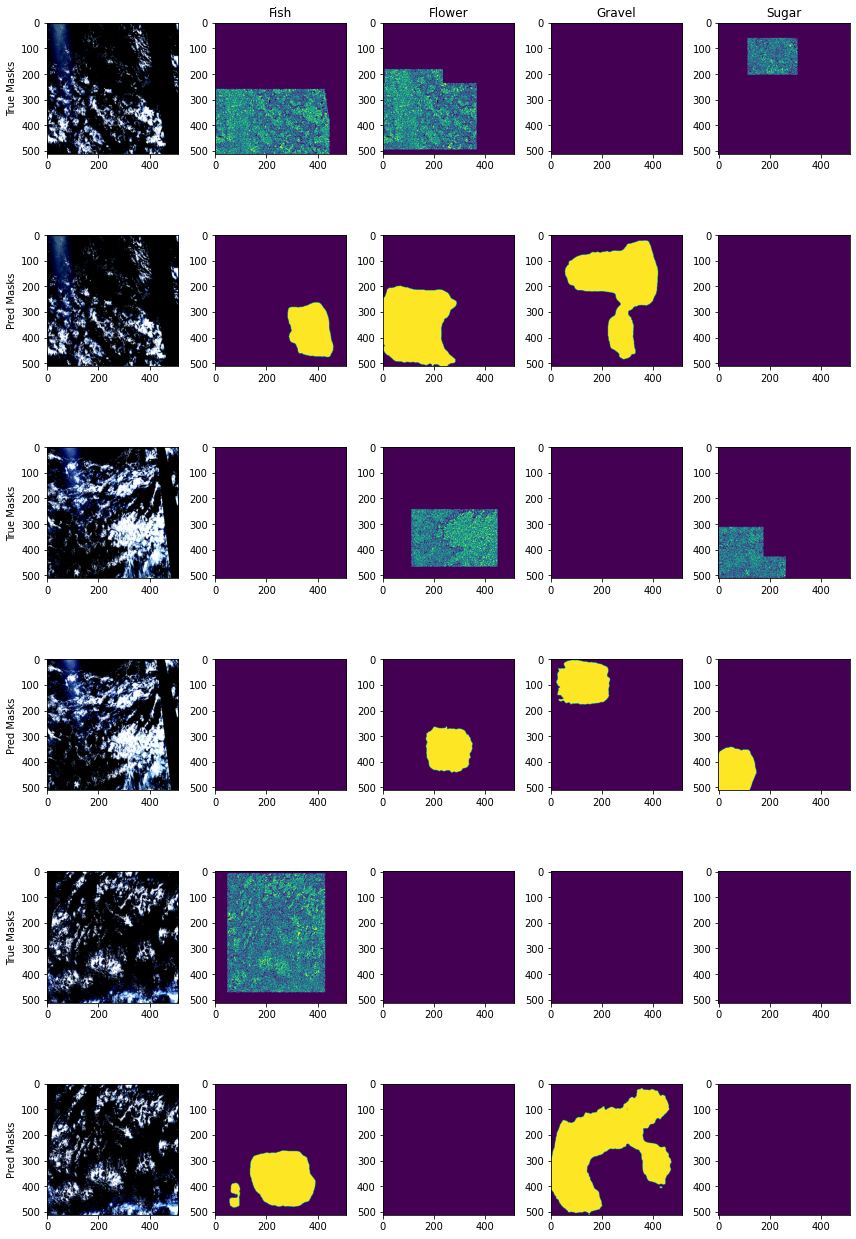

In [ ]:
# now show what the predicted mask is using a threshold
thresh = 0.5
sample_pred_masks = [(s>thresh).float() for s in sample_predictions]
show_predicted_masks(sample_pred_masks,sample_masks, original_images,classes=train_dataset.classes,cmap=None);